<a href="https://colab.research.google.com/github/tomreitz/cs766-computer-vision-project/blob/main/code/OpenCV_dlib_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is a proof-of-concept for using OpenCV and dlib to detect faces in images find facial landmarks (corners of eyes and mouth, nose/nostrils, eyebrows, etc.).

Code is based on these sources:
*   https://github.com/nlhkh/face-alignment-dlib
*   https://www.superdatascience.com/blogs/opencv-face-detection
*   https://pysource.com/2019/03/12/face-landmarks-detection-opencv-with-python/

The workhorse here is dlib, a cool C++ / Python library that uses an ensemble of regression trees to locate 68 predefined facial landmarks. Further info available at
* [dlib website](http://dlib.net/)
* [2014 paper "One Millisecond Face Alignment with an Ensemble of Regression Trees" by Kazemi et al.](https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Kazemi_One_Millisecond_Face_2014_CVPR_paper.pdf)
* [Pre-trained models for dlib](https://github.com/davisking/dlib-models/) (we're using shape_predictor_68_face_landmarks.dat here)

In [3]:
#import OpenCV library
import cv2
#import dlib facial landmark detection library
import dlib
#import NumPy for processing facial landmarks
import numpy as np
#import matplotlib library
import matplotlib.pyplot as plt
%matplotlib inline

def convertToRGB(img): 
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# uncomment the lines below to download/extract the necessary files on first run
#!wget https://tomreitz.github.io/cs766-computer-vision-project/data/pexels-photo-638196.jpeg
#!wget https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2
#!bunzip2 shape_predictor_68_face_landmarks.dat.bz2

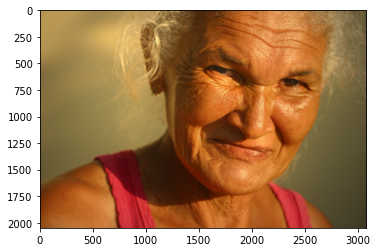

In [4]:
# load an image for testing
img = cv2.imread('pexels-photo-638196.jpeg')
# show the image
plt.imshow(convertToRGB(img))

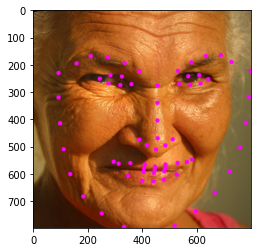

In [7]:
# code borrowed from https://github.com/nlhkh/face-alignment-dlib
LEFT_EYE_INDICES = [36, 37, 38, 39, 40, 41]
RIGHT_EYE_INDICES = [42, 43, 44, 45, 46, 47]

def rect_to_tuple(rect):
    left = rect.left()
    right = rect.right()
    top = rect.top()
    bottom = rect.bottom()
    return left, top, right, bottom

def extract_eye(shape, eye_indices):
    points = map(lambda i: shape.part(i), eye_indices)
    return list(points)

def extract_eye_center(shape, eye_indices):
    points = extract_eye(shape, eye_indices)
    xs = map(lambda p: p.x, points)
    ys = map(lambda p: p.y, points)
    return sum(xs) // 6, sum(ys) // 6

def extract_left_eye_center(shape):
    return extract_eye_center(shape, LEFT_EYE_INDICES)

def extract_right_eye_center(shape):
    return extract_eye_center(shape, RIGHT_EYE_INDICES)

def angle_between_2_points(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    tan = (y2 - y1) / (x2 - x1)
    return np.degrees(np.arctan(tan))

def get_rotation_matrix(p1, p2):
    angle = angle_between_2_points(p1, p2)
    x1, y1 = p1
    x2, y2 = p2
    xc = (x1 + x2) // 2
    yc = (y1 + y2) // 2
    M = cv2.getRotationMatrix2D((xc, yc), angle, 1)
    return M

def crop_image(image, det):
    left, top, right, bottom = rect_to_tuple(det)
    return image[top:bottom, left:right]

# detect faces in the image:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
scale = 2
img = cv2.imread('pexels-photo-638196.jpeg')
height, width = img.shape[:2]
s_height, s_width = height // scale, width // scale
img = cv2.resize(img, (s_width, s_height))
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# extract landmarks and align face
dets = detector(gray_img, 1)
if len(dets)==0:
    print("no face found :(")
    exit()
shape = predictor(gray_img, dets[0])
left_eye = extract_left_eye_center(shape)
right_eye = extract_right_eye_center(shape)
M = get_rotation_matrix(left_eye, right_eye)
rotated = cv2.warpAffine(img, M, (s_width, s_height), flags=cv2.INTER_CUBIC)
cropped = crop_image(rotated, dets[0])

# re-extract landmarks in aligned face and annottate them
dets = detector(cropped, 1)
if len(dets)==0:
    print("no face found :(")
    exit()
shape = predictor(cropped, dets[0])
for n in range(0, 68):
    x = shape.part(n).x
    y = shape.part(n).y
    cv2.circle(cropped, (x, y), 8, (255, 0, 255), -1)

# show the face with landmarks
plt.imshow(convertToRGB(cropped))

Next steps are to segment face into areas for each rhytide type based on landmarks, then do edge detection in each area to quantify wrinkles.